In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# OA11 -> OA21 conversion
oa_21 = gpd.read_file(os.path.join('data','oa11tooa21.geojson'))

In [3]:
# read the shapefile OA, add OA21 from gdf_21
oa = gpd.read_file(os.path.join('data','statistical-gis-boundaries-london','ESRI','OA_2011_London_gen_MHW.shp'))
oa['OA21CD'] = oa['OA11CD'].map(oa_21.set_index('OA11CD')['OA21CD'])

# read the flow file
df = pd.read_csv(os.path.join('data','flow','ODWP01EW_OA_v1','ODWP01EW_OA.csv'))

<Axes: >

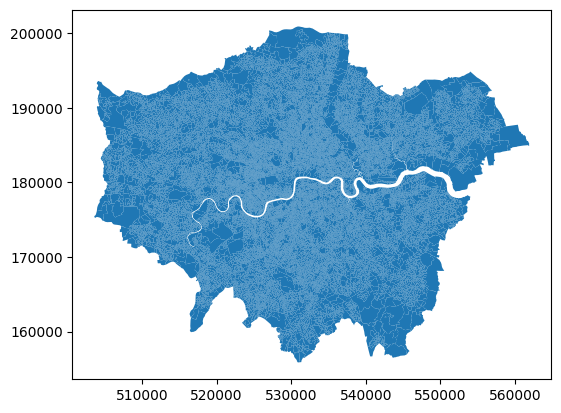

In [4]:
# plot gdf
oa.plot()

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10741185 entries, 0 to 10741184
Data columns (total 7 columns):
 #   Column                                        Dtype 
---  ------                                        ----- 
 0   Output Areas code                             object
 1   Output Areas label                            object
 2   OA of workplace code                          object
 3   OA of workplace label                         object
 4   Place of work indicator (4 categories) code   int64 
 5   Place of work indicator (4 categories) label  object
 6   Count                                         int64 
dtypes: int64(2), object(5)
memory usage: 573.6+ MB


<Axes: >

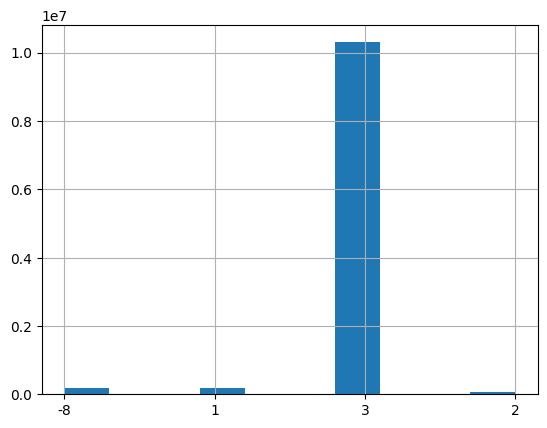

In [6]:
# visualise split of commuting pattern
df.iloc[:,4].astype('string').hist()

In [7]:
#filter forpalce of work indicator 3 (non work-from-home)
df_commute = df[df['Place of work indicator (4 categories) code'] == 3]
#filter for place where Output Areas code differs from OA of workplace code
df_commute = df_commute[df_commute['OA of workplace code'] != df_commute['Output Areas code']]
df_commute.head()

,Output Areas code,Output Areas label,OA of workplace code,OA of workplace label,Place of work indicator (4 categories) code,Place of work indicator (4 categories) label,Count
2,E00000001,E00000001,E00004731,E00004731,3,Working in the UK but not working at or from home,1
3,E00000001,E00000001,E00006038,E00006038,3,Working in the UK but not working at or from home,1
4,E00000001,E00000001,E00013547,E00013547,3,Working in the UK but not working at or from home,1
5,E00000001,E00000001,E00013548,E00013548,3,Working in the UK but not working at or from home,1
6,E00000001,E00000001,E00013789,E00013789,3,Working in the UK but not working at or from home,1


In [8]:
#group by OA of workplace code, summarise by count
df_commute_grouped = df_commute.groupby('OA of workplace code').count()
df_commute_grouped = df_commute_grouped.reset_index()
df_commute_grouped = df_commute_grouped[['OA of workplace code','Count']]


In [9]:
# join the two dataframes, rename the column
oa_joined = oa.merge(df_commute_grouped, left_on='OA21CD', right_on='OA of workplace code', how='left') \
                .drop(columns=['OA of workplace code']) \
                .rename(columns={'Count':'count_commuters'})


(500655.063, 564875.813, 153614.76995000002, 203186.88705)

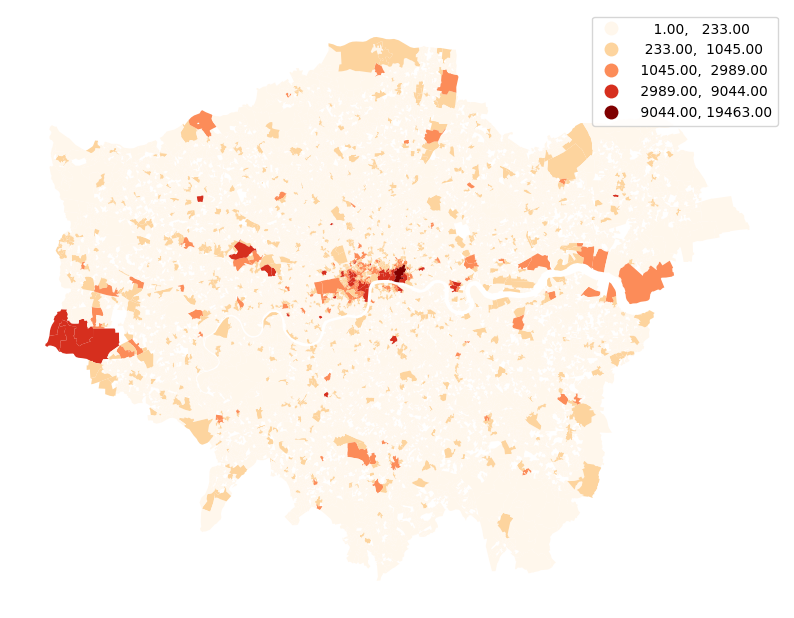

In [10]:
# plot the map, without axis, natural breaks
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
oa_joined.plot(column='count_commuters', ax=ax, legend=True, scheme='fisherjenks', k=5, cmap='OrRd')
plt.axis('off')

In [11]:
oa_joined.head()

,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,LSOA11NM,MSOA11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,OA21CD,count_commuters
0,E00023264,E01004612,E02000954,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 032C,Wandsworth 032,462,459,3,115.2,143,3.2,"POLYGON ((527635.452 171810.058, 527495.957 17...",E00023264,7.0
1,E00003359,E01000692,E02000128,E05000111,Chislehurst,E09000006,Bromley,E12000007,London,Bromley 002D,Bromley 002,269,259,10,36.7,133,1.9,"POLYGON ((543581.516 171132.486, 543704.000 17...",E00003359,323.0
2,E00023266,E01004615,E02000956,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 034B,Wandsworth 034,277,277,0,183.4,133,2.1,"POLYGON ((526613.539 171839.165, 526546.840 17...",E00023266,NaN
3,E00020264,E01004027,E02000809,E05000548,Riverside,E09000028,Southwark,E12000007,London,Southwark 003E,Southwark 003,415,415,0,96.1,191,2.2,"POLYGON ((533563.521 179695.146, 533351.118 17...",E00020264,200.0
4,E00023263,E01004613,E02000955,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 033D,Wandsworth 033,304,304,0,165.2,131,2.3,"POLYGON ((527822.000 172020.000, 527979.000 17...",E00023263,27.0


In [13]:
# Export to geojson
oa_joined.to_file(os.path.join('data','oa_inward_commuters.geojson'), driver='GeoJSON')